In [70]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path() # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

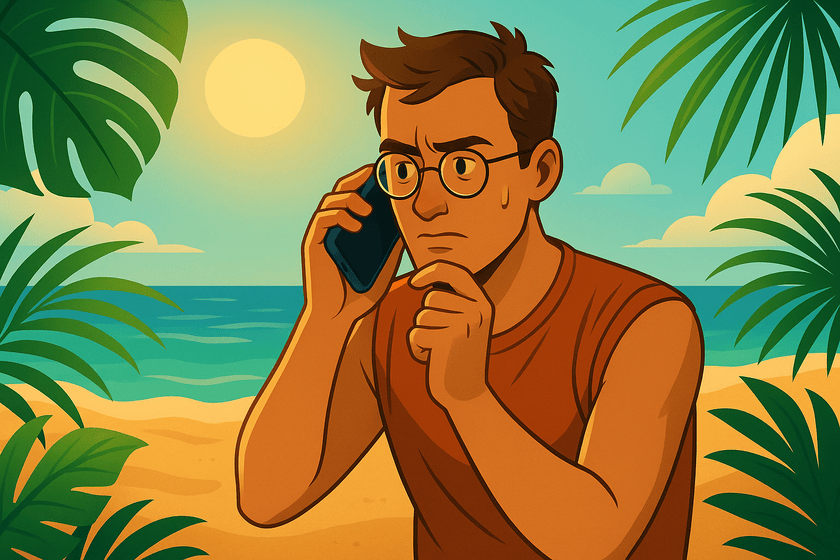

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [71]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [72]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[0]
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

Zacznę od przekopiowania subiektywnie cennych obserwacji z poprzedniego zadania, aby doprowadzić ramkę pandas do tej samej postaci, co ostatnio

In [73]:
age_median = titanic_df["Age"].median()
titanic_df["Age"] = titanic_df["Age"].fillna(age_median)

In [74]:
fare_mode = titanic_df["Fare"].mode()[0]
titanic_df['Fare'] = titanic_df["Fare"].fillna(fare_mode)

In [75]:
titanic_df["Cabin"] = titanic_df["Cabin"].fillna("Unknown")
titanic_df = titanic_df.dropna(subset="Embarked")

In [76]:
titanic_df["Relatives"] = titanic_df["SibSp"] + titanic_df["Parch"]
titanic_df[["Name", "Relatives"]]

,Name,Relatives
PassengerId,,
1,"Braund, Mr. Owen Harris",1
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
3,"Heikkinen, Miss. Laina",0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
5,"Allen, Mr. William Henry",0
...,...,...
887,"Montvila, Rev. Juozas",0
888,"Graham, Miss. Margaret Edith",0
889,"Johnston, Miss. Catherine Helen ""Carrie""",3


In [77]:
titanic_df["isAlone"] = (titanic_df["Relatives"] == 0).astype(int)
titanic_df[["Name", "isAlone"]]

,Name,isAlone
PassengerId,,
1,"Braund, Mr. Owen Harris",0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0
3,"Heikkinen, Miss. Laina",1
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0
5,"Allen, Mr. William Henry",1
...,...,...
887,"Montvila, Rev. Juozas",1
888,"Graham, Miss. Margaret Edith",1
889,"Johnston, Miss. Catherine Helen ""Carrie""",0


In [78]:
titanic_df["hasCabin"] = np.where(titanic_df["Cabin"] == "Unknown", 0, 1)
titanic_df[["Cabin", "hasCabin"]]

,Cabin,hasCabin
PassengerId,,
1,Unknown,0
2,C,1
3,Unknown,0
4,C,1
5,Unknown,0
...,...,...
887,Unknown,0
888,B,1
889,Unknown,0


In [79]:
ranges = [0, 1, 12, 18, 35, 60, np.inf]
labels = ['Toddler', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
titanic_df['ageGroup'] = pd.cut(titanic_df['Age'], bins=ranges, labels=labels, right=False)

titanic_df[["Name", "ageGroup"]]

,Name,ageGroup
PassengerId,,
1,"Braund, Mr. Owen Harris",Young Adult
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Adult
3,"Heikkinen, Miss. Laina",Young Adult
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Adult
5,"Allen, Mr. William Henry",Adult
...,...,...
887,"Montvila, Rev. Juozas",Young Adult
888,"Graham, Miss. Margaret Edith",Young Adult
889,"Johnston, Miss. Catherine Helen ""Carrie""",Young Adult


In [80]:
titanic_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [81]:
# ordinar encoding

embarked_mapping = {
    'C' : 1, 
    'Q' : 2, 
    'S' : 3
    }

cabin_mapping = {
    'A' : 1,
    'B' : 2,
    'C' : 3,
    'D' : 4,
    'E' : 5,
    'F' : 6,
    'G' : 7,
    'T' : 8
    }

age_groups_mapping = {
    "Toddler" : 0,
    "Child": 1,
    "Teenager": 2,
    "Young Adult": 3,
    "Adult": 4,
    "Senior": 5
}

gender_mapping = {
    "male" : 0,
    "female" : 1
}

In [82]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[0].map(cabin_mapping).fillna(0)
titanic_df['ageGroup'] = titanic_df['ageGroup'].map(age_groups_mapping)
titanic_df['Sex'] = titanic_df['Sex'].map(gender_mapping)
titanic_df['Embarked'] = titanic_df['Embarked'].map(embarked_mapping).fillna(0)

In [83]:
titanic_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,isAlone,hasCabin,ageGroup
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0.0,3,1,0,0,3
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,3.0,1,1,0,1,4
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0.0,3,0,1,0,3
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,3.0,3,1,0,1,4
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0.0,3,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,0.0,3,0,1,0,3
888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,2.0,3,0,1,1,3
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,0.0,3,3,0,0,3


## Baseline z naiwnym klasyfikatorem

In [84]:
from sklearn.dummy import DummyClassifier

x = titanic_df['Age']
y = titanic_df['Survived']

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x, y)

DummyClassifier(strategy='most_frequent')

In [85]:
dummy_clf.predict(x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Nie powiem, bardzo optymistyczny ten klasyfikator xdd

In [86]:
dummy_clf.score(x, y)

0.6175478065241845

### Dla testów spróbuję jeszcze z innym trybem klasyfikatora naiwnego, tamten zwracał same śmierci, bo miał predykować po "Most frequent"

In [87]:
from sklearn.dummy import DummyClassifier

x = titanic_df['Age']
y = titanic_df['Survived']

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(x, y)

DummyClassifier(strategy='stratified')

In [88]:
dummy_clf.predict(x)

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,

In [89]:
dummy_clf.score(x, y)

0.5253093363329584

### Ten dał gorszy wynik, zatem za punkt odniesienia. weźmiemy w przyblizeniu 0.62

In [90]:
titanic_df[['ageGroup', 'Sex', 'Cabin']]

,ageGroup,Sex,Cabin
PassengerId,,,
1,3,0,0.0
2,4,1,3.0
3,3,1,0.0
4,4,1,3.0
5,4,0,0.0
...,...,...,...
887,3,0,0.0
888,3,1,2.0
889,3,1,0.0


## Support Vector Machine

In [101]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV

x = [titanic_df['ageGroup'], titanic_df['Fare'], titanic_df['Cabin'], titanic_df['Sex'], titanic_df['isAlone'], titanic_df['hasCabin']]
y = titanic_df['Survived']
x = pd.concat(x, axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(svm.SVC(random_state=42), param_grid, cv=5)

grid_search.fit(x_train, y_train)

svm_clf = grid_search.best_estimator_

In [102]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'C': 100, 'kernel': 'linear'}
Best cross-validation score: 0.7918447749433664


In [103]:
y_pred = svm_clf.predict(x_test)
test_score = svm_clf.score(x_test, y_test)
test_score

0.7696629213483146

In [104]:
svm_clf.score(x, y)

0.78177727784027

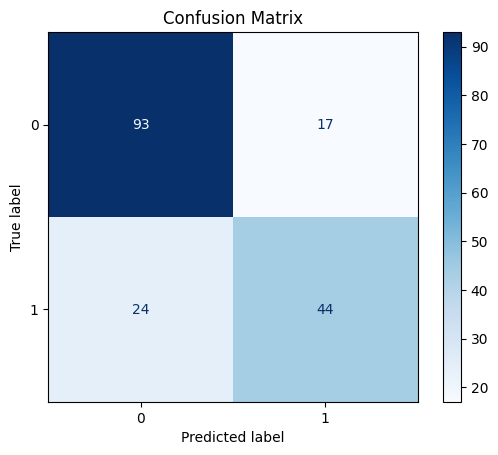

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Wniosek: model niemal bezbłędnie klasyfikował martwych pasazerów jako martwych. Duzo gorzej radził sobie z zywymi, którym dobry stan egzystencji, ze tak się wyrazę (sorki moja klawiatura nie umie w z z kropką), przypisał zaledwie 44% razy. Jak dla mnie to dobry wynik, bo lepiej zmartwić zywych, ze mogą nie przezyć niz robić pustą nadzieję martwym xD

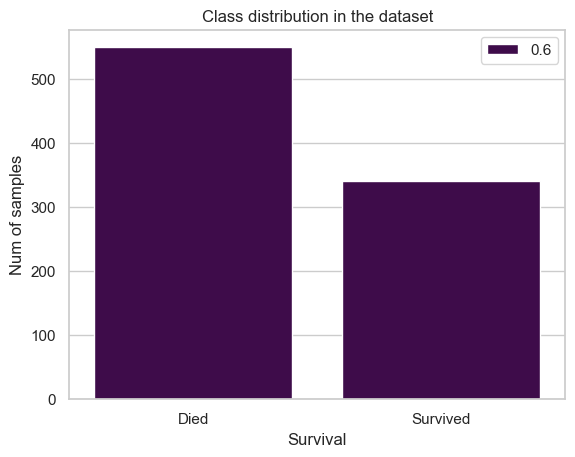

In [109]:
sns.countplot(x=y, palette='viridis', hue=0.6)
plt.title('Class distribution in the dataset')
plt.xlabel('Survival')
plt.ylabel('Num of samples')
plt.xticks([0, 1], ['Died', 'Survived'])
plt.show()

### Klasy są bardzo nierównomierne w uczeniu, co mogło w pewien sposób wpłynąć na jakość predykcji, ale równocześnie jest to naturalne przy tego typu datasecie. Faktycznie wpłynęło to na to, ze więcej osób zostało sklasyfikowanych jako martwi, przezywając, niz osób, które zostały sklasyfikowane jako ocalałe, ginąc.

## XGBoost

In [116]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

df = titanic_df.copy()

x = df[['ageGroup', 'Fare', 'Cabin', 'Sex', 'isAlone', 'hasCabin']]
y = df['Survived']

for col in ['Sex', 'Cabin', 'ageGroup']:
    df[col] = df[col].astype('category')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    enable_categorical=True,
    eval_metric='logloss',
    tree_method='hist'
)

model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [117]:
y_pred = model.predict(x_test)

In [120]:
accuracy_score(y_test, y_pred)

0.8033707865168539

### teraz spróbuję ztunningować te parametry

In [138]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300, 400, 500, 600],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        tree_method="hist",
        enable_categorical=True,
        eval_metric="logloss",
        random_state=42
    ),
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=1
)

grid_search.fit(x_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 486 candidates, totalling 1458 fits


{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 600,
 'subsample': 0.9}

### więc sprawdźmy z tymi parametrami! :D

In [127]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

df = titanic_df.copy()

x = df[['ageGroup', 'Fare', 'Cabin', 'Sex', 'isAlone', 'hasCabin']]
y = df['Survived']

for col in ['Sex', 'Cabin', 'ageGroup']:
    df[col] = df[col].astype('category')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=1.0,
    reg_lambda=1.0,
    random_state=42,
    enable_categorical=True,
    eval_metric='logloss',
    tree_method='hist'
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.8089887640449438

### zastosowałem te same najlepsze parametry z wyjątkiem liczby drzew, ją dałem wyzszą, bo zgodnie z wykresami, które przedstawiłem ponizej, liczba drzew zawsze pozytywnie wpływa tu na accuracy

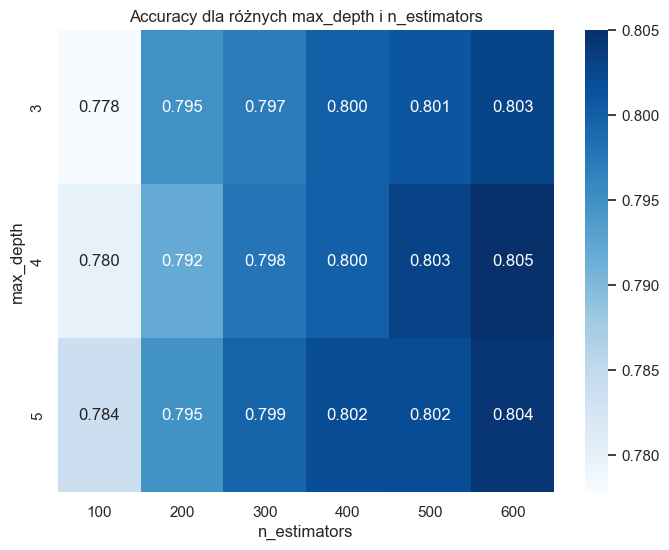

In [139]:
results = pd.DataFrame(grid_search.cv_results_)

pivot = results.pivot_table(
    values="mean_test_score",
    index="param_max_depth",
    columns="param_n_estimators"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues")
plt.title("Accuracy dla różnych max_depth i n_estimators")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()

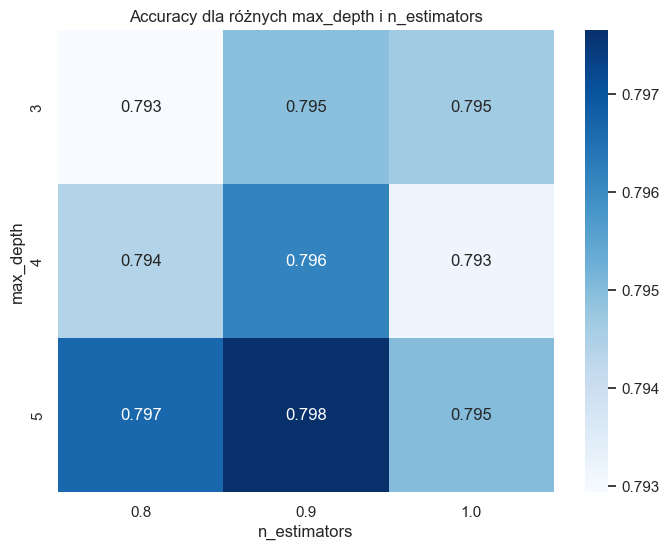

In [125]:
results = pd.DataFrame(grid_search.cv_results_)

pivot = results.pivot_table(
    values="mean_test_score",
    index="param_max_depth",
    columns="param_subsample"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues")
plt.title("Accuracy dla różnych max_depth i n_estimators")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()

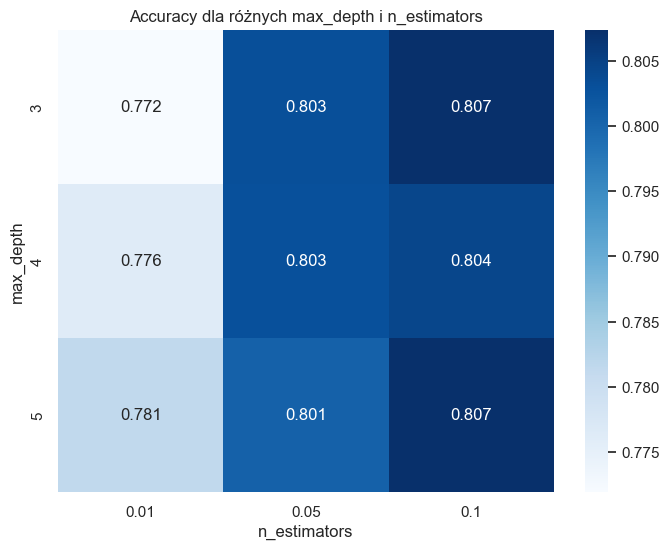

In [126]:
results = pd.DataFrame(grid_search.cv_results_)

pivot = results.pivot_table(
    values="mean_test_score",
    index="param_max_depth",
    columns="param_learning_rate"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues")
plt.title("Accuracy dla różnych max_depth i n_estimators")
plt.ylabel("max_depth")
plt.xlabel("n_estimators")
plt.show()

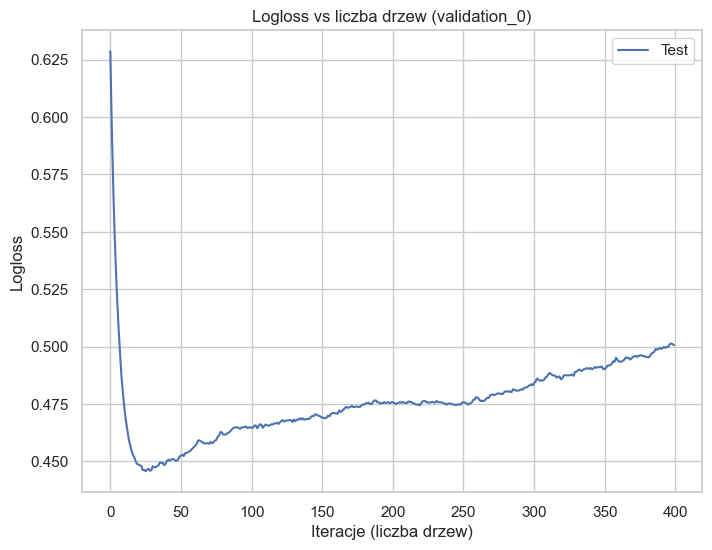

In [131]:
import xgboost as xgb
import matplotlib.pyplot as plt

model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=1.0,
    reg_lambda=1.0,
    random_state=42,
    enable_categorical=True,
    eval_metric='logloss',
    tree_method='hist'
)

model.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    verbose=False
)

evals_result = model.evals_result()
epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(epochs)

plt.figure(figsize=(8,6))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Test')
plt.title("Logloss vs liczba drzew (validation_0)")
plt.xlabel("Iteracje (liczba drzew)")
plt.ylabel("Logloss")
plt.legend()
plt.show()

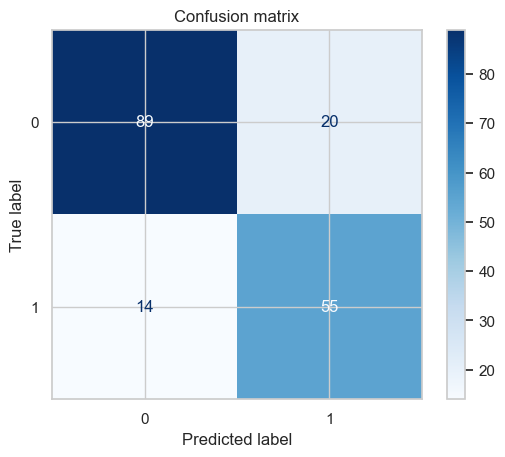

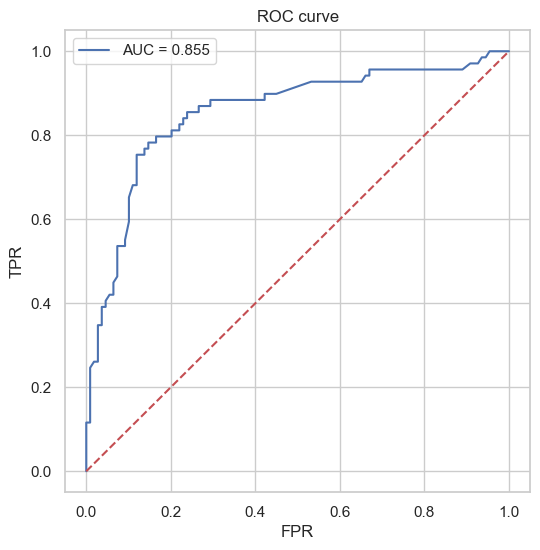

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:,1]

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
plt.show()

### Wygląda na to, ze skoro pole pod krzywą to 0.855, to model w zdecydowanej większości przypadków poprawnie spośród pary osób, gdzie jedna przezyła, a jedna nie, wskaze tą, która faktycznie przezyła. Moje pozostałe wnioski co do tego modelu:
1. Zwiększenie liczby drzew zawsze pozytywnie wpływa na jakość predykcji, ale między 400 a 500 drzewami róznica ta przestaje być jakkolwiek znacząca.
2. Dla małej ilości drzew zwiększanie głębokości pojedynczego drzewa pozytywnie wpływa na jakość predykcji, w przypadku ich większej ilości nie jest to reguła.
3. Dla parametrów, na podstawie których klasyfikowałem pasazerów, XGBoost był nieznacznie (o około 2%) lepszym algorytmem niz Support Vectors Machine.
4. Oba klasyfikatory radzą sobie znacznie lepiej niz klasyfikator naiwny z zawrtonym wynikiem 62%, więc dobór algorytmów i cech dla modelu uznaję za względnie udany.

## Na koniec sprawdzę, czy ja przeżyłbym Titanica, kupując bilet losowo

In [134]:
person = pd.DataFrame([{
    "ageGroup": 3, # bo mam 22 lata
    "Fare": 30.0, # więcej za bilet bym nie dał, jeśli liczymy w euro xd
    "Cabin": "C", # na pewno miałbym kabinę, ale jej wybór był losowy
    "Sex": "male", # niewątpliwie jestem mężczyzną
    "isAlone": 1, # raczej rodzina by nie popłynęła na rejs, boją się wody XD
    "hasCabin": 1 # ustaliliśmy wyzej, ze miałbym kabinę
}])

In [137]:
for col in ["Sex", "Cabin", "ageGroup"]:
    person[col] = person[col].astype("category")

pred = model.predict(person)
proba = model.predict_proba(person)

print("Did I survive?: " "Yes" if pred[0] == 1 else "No")
print("Prob of not dying:", proba[0][1])

Did I survive?: Yes
Prob of not dying: 0.94125736


### bardzo lubię moje żyćko, więc wynik mnie ucieszył :D